In [73]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import yaml
import h5py
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import dotenv


import sys
import os
sys.path.append(os.path.abspath('../..'))
from models.mlp import MLPClassifier
from models.feat2loc_model import get_agg_model
from data.collate_fn import test_collate_fn, collate_fn
from data.dataset import EmbeddingDataset
from utils.metrics import *

In [ ]:
#GET NECESSARY .ENV VARIABLES
dotenv.load_dotenv('../../.env')
SWEEP_EXP_DIR=os.getenv("SWEEP_EXP_DIR")
SWEEP_ANALYSIS_DIR=os.getenv("SWEEP_ANALYSIS_DIR")
PLM_EMBEDDING_DIR=os.getenv("PLM_EMBEDDING_DIR")
FIG_DIR = "../../figures/variant"

In [177]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config
LEVEL_CLASSES = load_config("../../datasets/final/hierarchical_label_set.yaml")

lacoste_metadata = pd.read_csv("../../datasets/final/LaCoste_metadata.csv")
combined_trainset = pd.read_csv("../../datasets/final/hpa_uniprot_combined_trainset.csv")
#Look at overlap of Lacoste data with training set
lacoste_metadata = lacoste_metadata.merge(combined_trainset, how="left", left_on="Uniprot", right_on="uniprot_id", suffixes=["", "_train"])
lacoste_metadata.loc[:, "in_trainset"] = lacoste_metadata.uniprot_id.notna()

In [79]:
def get_embedding_dim(plm):
    if plm == "ProtT5":
        return 1024
    elif plm == "ProtBert":
        return 1024
    elif plm == "ESM2":
        return 2560
    elif plm == "ESM3":
        return 1536
    else:
        raise ValueError("Invalid exp_name")

In [80]:
def load_model_weights(model, model_path, prefix):
    model_weights = torch.load(model_path, map_location="cpu", weights_only=False)
    filtered_weights = {
        k[len(prefix) + 1 :]: v
        for k, v in model_weights["state_dict"].items()
        if k.startswith(prefix)
    }
    op = model.load_state_dict(filtered_weights)
    print(op)
    return model

In [ ]:
def get_best_model_path(train_set="hpa_uniprot_combined_trainset", level=1):
    avg_metrics = pd.read_csv(f"{SWEEP_ANALYSIS_DIR}/overall_metrics.csv")

    #DROP DUPLICATE RUNS
    idx = avg_metrics.groupby(
        ["exp_name",
        "category_level",
        "metadata_file",
        "clip_len",
        "agg_method",
        "mlp_dropout",
        "loss"
        ])["macro_ap"].idxmax()
    avg_metrics = avg_metrics.loc[idx].reset_index(drop=True)


    #GET BEST MODEL
    best_model = avg_metrics.iloc[avg_metrics[
        (avg_metrics.metadata_file == train_set)  &
        (avg_metrics.category_level == f"level{level}")
    ].macro_ap.idxmax()]

    run_id = best_model.run_id
    plm = best_model.exp_name

    #PATH TO RUN WITH BEST MODEL
    path_to_best_model = f"{SWEEP_EXP_DIR}/{plm}_hpa_uniprot_combined_trainset/{run_id}"

    return path_to_best_model, best_model

best_model, PATH_TO_BEST_MODEL = path_to_best_model()

In [81]:
avg_metrics = pd.read_csv(f"{SWEEP_ANALYSIS_DIR}/overall_metrics.csv")

#DROP DUPLICATE RUNS
idx = avg_metrics.groupby(
    ["exp_name",
    "category_level",
    "metadata_file",
    "clip_len",
    "agg_method",
    "mlp_dropout",
    "loss"
    ])["macro_ap"].idxmax()
avg_metrics = avg_metrics.loc[idx].reset_index(drop=True)


#GET BEST MODEL
best_model = avg_metrics.iloc[avg_metrics[
    (avg_metrics.metadata_file == "hpa_uniprot_combined_trainset")  &
    (avg_metrics.category_level == "level1")
].macro_ap.idxmax()]

best_model

exp_name                                 ProtT5
category_level                           level1
metadata_file     hpa_uniprot_combined_trainset
clip_len                                   1024
agg_method               MultiHeadAttentionPool
loss                           SigmoidFocalLoss
mlp_dropout                                 0.0
run_id                                 ze5s13k3
macro_ap                               0.427865
micro_ap                                  0.684
acc                                    0.935638
acc_samples                            0.272155
f1_macro                               0.403011
f1_micro                               0.585244
jaccard_macro                          0.280789
jaccard_micro                          0.413672
rocauc_macro                           0.882472
rocauc_micro                           0.944191
mlrap                                  0.809081
coverage_error                         2.736235
num_labels                             1

Filter data for variatns where mutated residue is not clipped out

In [178]:
def mutation_postion(s):
    gene_name = s.replace(",", "")
    split = s.split(" ")
    gene = split[0]
    mutations = split[1:]
    positions = [int(m[1:-1]) for m in mutations]
    return positions

lacoste_metadata.loc[lacoste_metadata.mutated, "mutation_pos"] = lacoste_metadata[lacoste_metadata.mutated].Variant.apply(mutation_postion)
filt = lacoste_metadata.apply(lambda row: not row.mutated or all([pos <= best_model.clip_len/2 or pos>=len(row.sequence)-best_model.clip_len/2 for pos in row.mutation_pos]), axis=1)
lacoste_metadata = lacoste_metadata[filt]

In [83]:
plm=best_model.exp_name
trainset="hpa_uniprot_combined_trainset"
level="level1"
clip_len=best_model.clip_len
agg_method=best_model.agg_method
loss=best_model.loss
run_id=best_model.run_id
embedding_dim = get_embedding_dim(plm)
categories = LEVEL_CLASSES[level]
n_categories = len(categories)

#GET MODEL FOR EACH FOLD
fold_model_paths = [
    f"{SWEEP_EXP_DIR}/{plm}_{trainset}/{run_id}/fold_{i}/models/best_model_acc.ckpt"
    for i in range(5)
]

#GET THRESHOLDS
threshold_path = f"{SWEEP_EXP_DIR}/{plm}_{trainset}/{run_id}/all_thresholds.npy"

#LOAD DATA
test_dataset = EmbeddingDataset(
    f"{PLM_EMBEDDING_DIR}/Lacoste_ProtT5-4k.h5",
    "../../datasets/final/lacoste_metadata.csv",
    "level1",
    clip_len=clip_len,
    id_col="Variant",
    test_mode=True
)

test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False, collate_fn=test_collate_fn
)

In [85]:
#GET PREDICTIONS
agg_model = get_agg_model(agg_method, embedding_dim, clip_len)

mlp_embedding_dim = (
    embedding_dim * 2
    if agg_method == "LightAttentionPool"
    else embedding_dim
)

mlp_config = {
    "input_dim": mlp_embedding_dim,
    "num_classes": n_categories,
    "hidden_dim": 512,
    "num_hidden_layers": 2,
    "dropout": 0.2,
}

mlp_model = MLPClassifier(**mlp_config)

all_ids = []
all_preds = []
all_preds_bin = []
all_attention = []
all_thresholds = np.load(threshold_path)
true_locations = []
for i in range(5):
    #Rewrite so that compute predictions using each fold with each set of thresholds
    fold_model_path = fold_model_paths[i]
    thresholds = torch.tensor(all_thresholds[i,:])

    agg_model = load_model_weights(agg_model, fold_model_path, "model")
    mlp_model = load_model_weights(mlp_model, fold_model_path, "mlp_classifier")
    
    fold_preds = []
    fold_preds_bin = []
    fold_attention = []
    with torch.no_grad():
        agg_model.eval()
        mlp_model.eval()

        for batch in tqdm.tqdm(test_loader):
            gene_name, seqs, embeddings, masks, locations = batch
            if i == 0:
                all_ids.append(gene_name)
                true_locations.append(locations)
            pooled_embedding, attention = agg_model(embeddings, masks)
            preds = mlp_model(pooled_embedding)
            preds = torch.sigmoid(preds)
            preds_bin = preds > thresholds

            fold_preds.append(preds)
            fold_preds_bin.append(preds_bin)
            fold_attention.append(attention)

        
    preds = torch.vstack(fold_preds)
    preds_bin = torch.vstack(fold_preds_bin)
    attention = torch.vstack(fold_attention)
    
    all_preds.append(preds)
    all_preds_bin.append(preds_bin)
    all_attention.append(attention)

preds = torch.stack(all_preds).mean(axis=0)
preds_bin = (torch.stack(all_preds_bin).float().mean(axis=0) > 0.5).float()
attention = torch.stack(all_attention).mean(axis=0)
all_ids = sum(all_ids, [])
true_locations = torch.vstack(true_locations)

<All keys matched successfully>
<All keys matched successfully>


100%|██████████| 52/52 [00:36<00:00,  1.41it/s]


<All keys matched successfully>
<All keys matched successfully>


100%|██████████| 52/52 [00:37<00:00,  1.40it/s]


<All keys matched successfully>
<All keys matched successfully>


100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


<All keys matched successfully>
<All keys matched successfully>


100%|██████████| 52/52 [00:35<00:00,  1.46it/s]


<All keys matched successfully>
<All keys matched successfully>


100%|██████████| 52/52 [00:38<00:00,  1.36it/s]


In [179]:
output = {all_ids[i]: (preds[i], preds_bin[i], attention[i]) for i in range(len(all_ids))}

In [180]:
def onehot_to_string(onehot, classes):
    return ";".join([classes[i] for i in range(len(onehot)) if onehot[i]==1])

lacoste_metadata.loc[:, "predicted_loc"] = lacoste_metadata.Variant.apply(lambda x: onehot_to_string(output[x][1], LEVEL_CLASSES["level1"]))
lacoste_metadata.loc[:, "preds"] = lacoste_metadata.Variant.apply(lambda x: output[x][0])
lacoste_metadata.loc[:, "preds_bin"] = lacoste_metadata.Variant.apply(lambda x: output[x][1])
lacoste_metadata.loc[:, "attention"] = lacoste_metadata.Variant.apply(lambda x: output[x][2])

In [181]:
lacoste_metadata.loc[:, "level1"] = lacoste_metadata.level1.str.split(";").apply(set)
lacoste_metadata.loc[:, "predicted_loc"] = lacoste_metadata.predicted_loc.str.split(";").apply(set)
lacoste_metadata.loc[:, "correct"] = lacoste_metadata.level1 == lacoste_metadata.predicted_loc
lacoste_metadata.loc[:, "overlap"] = lacoste_metadata.apply(lambda x: x.level1.intersection(x.predicted_loc), axis=1)
lacoste_metadata.loc[:, "contained"] = lacoste_metadata.apply(lambda x: x.level1.issubset(x.predicted_loc), axis=1)

In [182]:
#Add Wildtype locations to all rows
wt_locs = lacoste_metadata[~lacoste_metadata.mutated][["Variant", "level1"]].set_index("Variant").to_dict()["level1"]
wt_pred = lacoste_metadata[~lacoste_metadata.mutated][["Variant", "predicted_loc"]].set_index("Variant").to_dict()["predicted_loc"]

lacoste_metadata.loc[:, "wt_locs"] = lacoste_metadata.Gene.map(wt_locs)
lacoste_metadata.loc[:, "wt_pred"] = lacoste_metadata.Gene.map(wt_pred)

In [183]:
#Add colums for wildtype locations and wildtype predictions
wt_locs = lacoste_metadata[~lacoste_metadata.mutated][["Uniprot", "level1"]].set_index("Uniprot").to_dict()["level1"]
wt_pred_locs = lacoste_metadata[~lacoste_metadata.mutated][["Uniprot", "predicted_loc"]].set_index("Uniprot").to_dict()["predicted_loc"]

lacoste_metadata.loc[:, "wt_locs"] = lacoste_metadata.Uniprot.map(wt_locs)
lacoste_metadata.loc[:, "wt_pred_locs"] = lacoste_metadata.Uniprot.map(wt_pred_locs)
lacoste_metadata.loc[:, "wt_pred_correct"] = lacoste_metadata.wt_locs != lacoste_metadata.wt_pred_locs
lacoste_metadata.loc[:, "wt_pred_overlap"] = lacoste_metadata.apply(lambda x: x.wt_locs.intersection(x.wt_pred_locs), axis=1)
lacoste_metadata.loc[:, "wt_pred_contained"] = lacoste_metadata.apply(lambda x: x.wt_locs.issubset(x.wt_pred_locs), axis=1)

lacoste_metadata.loc[:, "pred_mislocalized_from_true_wt"] = lacoste_metadata.predicted_loc != lacoste_metadata.wt_locs
lacoste_metadata.loc[:, "pred_mislocalized_from_pred_wt"] = lacoste_metadata.predicted_loc != lacoste_metadata.wt_pred

In [184]:
def set_to_numpy(s, classes=LEVEL_CLASSES["level1"]):
    return np.array([1 if loc in s else 0 for loc in classes])

lacoste_metadata.loc[:, "targets"] = lacoste_metadata.level1.apply(set_to_numpy)

In [185]:
def zscore(t):
    return (t-t.mean())/t.std()

def minmax(t):
    return (t-t.min())/(t.max()-t.min())

#Save wildtype attention
wt_attn_dict = lacoste_metadata[~lacoste_metadata.mutated][["Gene", "attention"]].set_index("Gene").to_dict()["attention"]
lacoste_metadata.loc[:, "wt_attention"] = lacoste_metadata.Gene.map(wt_attn_dict)

#Apply z-scoring to all attention values
lacoste_metadata.loc[:, "z_attention"] = lacoste_metadata.attention.apply(zscore)
lacoste_metadata.loc[:, "z_wt_attention"] = lacoste_metadata.wt_attention.apply(zscore)

#Normalize all attention values between [0,1]
lacoste_metadata.loc[:, "norm_attention"] = lacoste_metadata.attention.apply(minmax)
lacoste_metadata.loc[:, "norm_wt_attention"] = lacoste_metadata.wt_attention.apply(minmax)

lacoste_metadata.loc[lacoste_metadata.mutated, "mutated_z_attention"] = lacoste_metadata[lacoste_metadata.mutated].apply(
    lambda row: [
        row.z_attention[pos-1].item() if pos <=best_model.clip_len else row.z_attention[len(row.sequence) - pos - 1].item()
        for pos in row.mutation_pos
        ], axis=1
    )

lacoste_metadata.loc[lacoste_metadata.mutated, "unmutated_z_attention"] = lacoste_metadata[lacoste_metadata.mutated].apply(
    lambda row: [
        row.z_attention[pos-1].item() if pos <=best_model.clip_len else row.z_wt_attention[len(row.sequence) - pos - 1].item()
        for pos in row.mutation_pos
        ], axis=1
    )

lacoste_metadata.loc[lacoste_metadata.mutated, "mutated_norm_attention"] = lacoste_metadata[lacoste_metadata.mutated].apply(
    lambda row: [
        row.norm_attention[pos-1].item() if pos <=best_model.clip_len else row.norm_attention[len(row.sequence) - pos - 1].item()
        for pos in row.mutation_pos
        ], axis=1
    )

lacoste_metadata.loc[lacoste_metadata.mutated, "unmutated_norm_attention"] = lacoste_metadata[lacoste_metadata.mutated].apply(
    lambda row: [
        row.norm_attention[pos-1].item() if pos <=best_model.clip_len else row.norm_wt_attention[len(row.sequence) - pos - 1].item()
        for pos in row.mutation_pos
        ], axis=1
    )

In [186]:
wildtype = lacoste_metadata[(~lacoste_metadata.mutated) & ~(lacoste_metadata.in_trainset)]
mutated = lacoste_metadata[(lacoste_metadata.mutated) & ~(lacoste_metadata.in_trainset)]
stationary = lacoste_metadata[(lacoste_metadata.mutated) & (~lacoste_metadata.mislocalized) & ~(lacoste_metadata.in_trainset)]
mislocalized = lacoste_metadata[(lacoste_metadata.mislocalized)& ~(lacoste_metadata.in_trainset)]
lacoste_in_trainset = lacoste_metadata[(lacoste_metadata.in_trainset)]
lacoste_notin_trainset = lacoste_metadata[~(lacoste_metadata.in_trainset)]
#lacoste_in_trainset = lacoste_metadata[(lacoste_metadata.in_trainset) & ~(lacoste_metadata.mutated)]
#lacoste_notin_trainset = lacoste_metadata[~(lacoste_metadata.in_trainset) & ~(lacoste_metadata.mutated)]

In [146]:
wildtype_preds = np.array(wildtype.preds.apply(lambda x: x.numpy()).to_list())
wildtype_preds_bin = np.array(wildtype.preds_bin.apply(lambda x: x.numpy()).to_list())
wildtype_targets = np.array(wildtype.targets.to_list())
wildtype_attn = np.array(wildtype.attention.apply(lambda x: x.numpy()).to_list())

stationary_preds = np.array(stationary.preds.apply(lambda x: x.numpy()).to_list())
stationary_preds_bin = np.array(stationary.preds_bin.apply(lambda x: x.numpy()).to_list())
stationary_targets = np.array(stationary.targets.to_list())
stationary_attn = np.array(stationary.attention.apply(lambda x: x.numpy()).to_list())

mislocalized_preds = np.array(mislocalized.preds.apply(lambda x: x.numpy()).to_list())
mislocalized_preds_bin = np.array(mislocalized.preds_bin.apply(lambda x: x.numpy()).to_list())
mislocalized_targets = np.array(mislocalized.targets.to_list())
mislocalized_attn = np.array(mislocalized.attention.apply(lambda x: x.numpy()).to_list())


lacoste_in_trainset_preds = np.array(lacoste_in_trainset.preds.apply(lambda x: x.numpy()).to_list())
lacoste_in_trainset_preds_bin = np.array(lacoste_in_trainset.preds_bin.apply(lambda x: x.numpy()).to_list())
lacoste_in_trainset_targets = np.array(lacoste_in_trainset.targets.to_list())
lacoste_in_trainset_attn = np.array(lacoste_in_trainset.attention.apply(lambda x: x.numpy()).to_list())

lacoste_notin_trainset_preds = np.array(lacoste_notin_trainset.preds.apply(lambda x: x.numpy()).to_list())
lacoste_notin_trainset_preds_bin = np.array(lacoste_notin_trainset.preds_bin.apply(lambda x: x.numpy()).to_list())
lacoste_notin_trainset_targets = np.array(lacoste_notin_trainset.targets.to_list())
lacoste_notin_trainset_attn = np.array(lacoste_notin_trainset.attention.apply(lambda x: x.numpy()).to_list())

In [139]:
print(f"{len(lacoste_in_trainset)}/{len(wildtype)} proteins not in trainset")
print(f"{len(lacoste_notin_trainset)}/{len(wildtype)} proteins not in trainset")

184/103 proteins not in trainset
226/103 proteins not in trainset


In [147]:
wildtype_metrics = get_all_metrics(wildtype_targets, wildtype_preds, wildtype_preds_bin, LEVEL_CLASSES["level1"])
stationary_metrics = get_all_metrics(stationary_targets, stationary_preds, stationary_preds_bin, LEVEL_CLASSES["level1"])
mislocalized_metrics = get_all_metrics(mislocalized_targets, mislocalized_preds, mislocalized_preds_bin, LEVEL_CLASSES["level1"])
lacoste_in_trainset_metrics = get_all_metrics(lacoste_in_trainset_targets, lacoste_in_trainset_preds, lacoste_in_trainset_preds_bin, LEVEL_CLASSES["level1"])
lacoste_notin_trainset_metrics = get_all_metrics(lacoste_notin_trainset_targets, lacoste_notin_trainset_preds, lacoste_notin_trainset_preds_bin, LEVEL_CLASSES["level1"])

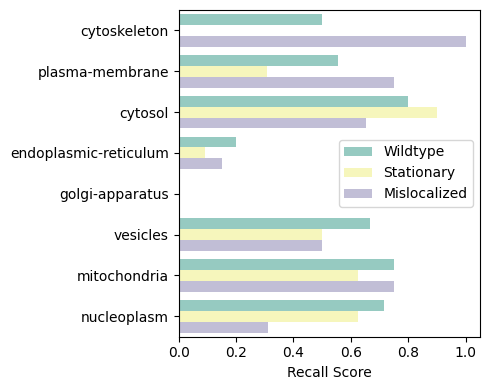

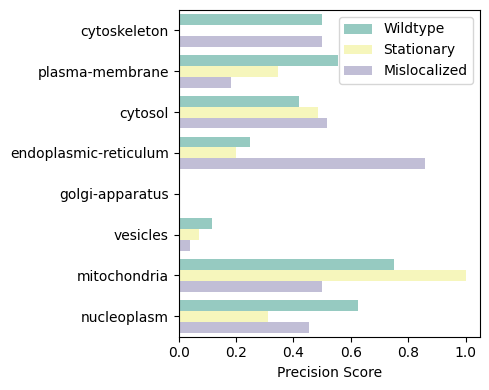

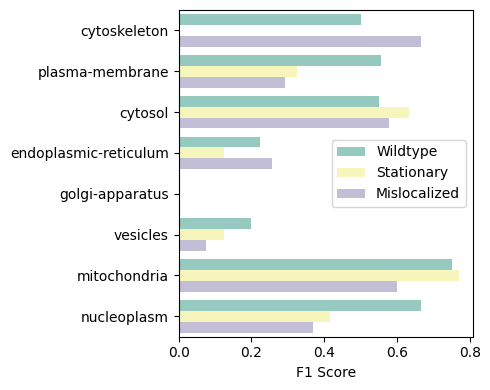

In [149]:
perclass_metrics = [("recall_perclass", "Recall"), ("precision_perclass", "Precision"), ("f1_perclass", "F1")]
for perclass_metric, name in perclass_metrics:
    wildtype_scores  = np.array([
        wildtype_metrics["category_perclass"], 
        list(wildtype_metrics[perclass_metric]), 
        ["Wildtype" for i in range(len(wildtype_metrics["category_perclass"]))]])
    stationary_scores  = np.array([
        stationary_metrics["category_perclass"], 
        list(stationary_metrics[perclass_metric]), 
        ["Stationary" for i in range(len(stationary_metrics["category_perclass"]))]])
    mislocalized_scores = np.array([
        mislocalized_metrics["category_perclass"], 
        list(mislocalized_metrics[perclass_metric]), 
        ["Mislocalized" for i in range(len(mislocalized_metrics["category_perclass"]))]])

    scores_data = np.hstack([
        wildtype_scores,
        stationary_scores,
        mislocalized_scores
    ]).T

    barplot_df = pd.DataFrame(scores_data, columns=["locations", "score", "condition"])
    barplot_df['score'] = pd.to_numeric(barplot_df['score'], errors='coerce')

    # Only look at common classes
    common_classes = set(wildtype_metrics["category_perclass"])
    common_classes = common_classes.intersection(set(stationary_metrics["category_perclass"]))
    common_classes = common_classes.intersection(set((mislocalized_metrics["category_perclass"])))
    barplot_df = barplot_df[barplot_df.locations.isin(common_classes)]

    plt.figure(figsize=(5, 4))
    sns.barplot(data=barplot_df, 
                y='locations', 
                x='score', 
                hue='condition', 
                orient='h',
                palette="Set3")
    plt.ylabel('')
    plt.xlabel(f"{name} Score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/lacoste_{name}.pdf", bbox_inches='tight', dpi=300)
    plt.show()


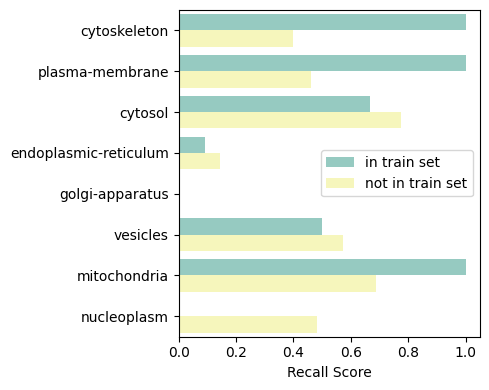

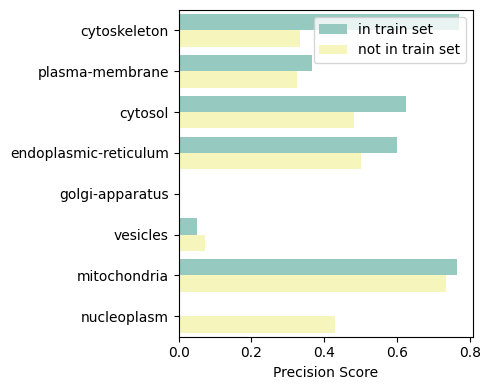

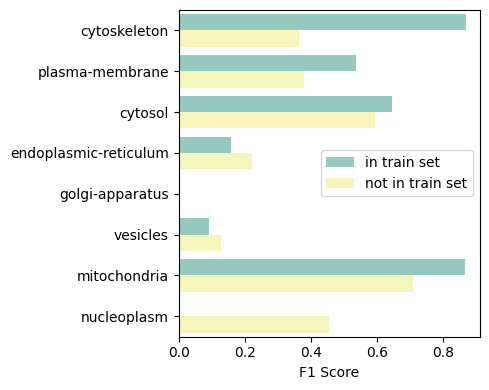

In [142]:
perclass_metrics = [("recall_perclass", "Recall"), ("precision_perclass", "Precision"), ("f1_perclass", "F1")]
for perclass_metric, name in perclass_metrics:
    lacoste_in_trainset_scores  = np.array([
        lacoste_in_trainset_metrics["category_perclass"], 
        list(lacoste_in_trainset_metrics[perclass_metric]), 
        ["in train set" for i in range(len(lacoste_in_trainset_metrics["category_perclass"]))]])
    lacoste_notin_trainset_scores  = np.array([
        lacoste_notin_trainset_metrics["category_perclass"], 
        list(lacoste_notin_trainset_metrics[perclass_metric]), 
        ["not in train set" for i in range(len(lacoste_notin_trainset_metrics["category_perclass"]))]])

    scores_data = np.hstack([
        lacoste_in_trainset_scores,
        lacoste_notin_trainset_scores
    ]).T

    barplot_df = pd.DataFrame(scores_data, columns=["locations", "score", "condition"])
    barplot_df['score'] = pd.to_numeric(barplot_df['score'], errors='coerce')

    # Only look at common classes
    common_classes = set(wildtype_metrics["category_perclass"])
    common_classes = common_classes.intersection(set(stationary_metrics["category_perclass"]))
    common_classes = common_classes.intersection(set((mislocalized_metrics["category_perclass"])))
    barplot_df = barplot_df[barplot_df.locations.isin(common_classes)]

    plt.figure(figsize=(5, 4))
    sns.barplot(data=barplot_df, 
                y='locations', 
                x='score', 
                hue='condition', 
                orient='h',
                palette="Set3")
    plt.ylabel('')
    plt.xlabel(f"{name} Score")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/lacoste_intrainset_{name}.pdf", bbox_inches='tight', dpi=300)
    plt.show()

In [152]:
print(len(wildtype))
print(len(stationary))
print(len(mislocalized))

58
76
92


Wild-type exact accuracy: 0.27586206896551724
Stationary exact accuracy: 0.18421052631578946
Mislocalized exact accuracy: 0.17391304347826086

Wild-type contained accuracy: 0.4827586206896552
Stationary contained accuracy: 0.4473684210526316
Mislocalized contained accuracy: 0.33695652173913043

Wild-type overlap accuracy: 0.5
Stationary contained accuracy: 0.47368421052631576
Mislocalized overlap accuracy: 0.40217391304347827


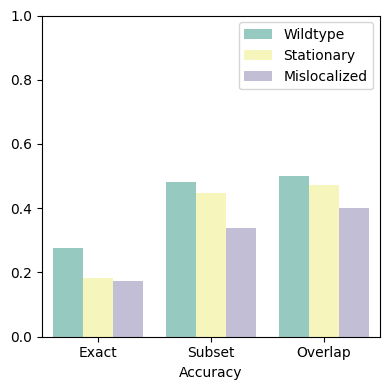

In [148]:
acc_data = []

acc = wildtype.correct.mean()
print(f"Wild-type exact accuracy: {acc}")
acc_data.append(["Wildtype", "Exact", acc])
acc = stationary.correct.mean()
print(f"Stationary exact accuracy: {acc}")
acc_data.append(["Stationary", "Exact", acc])
acc = mislocalized.correct.mean()
print(f"Mislocalized exact accuracy: {acc}\n")
acc_data.append(["Mislocalized", "Exact", acc])



acc = wildtype.contained.mean()
print(f"Wild-type contained accuracy: {acc}")
acc_data.append(["Wildtype", "Subset", acc])
acc = stationary.contained.mean()
print(f"Stationary contained accuracy: {acc}")
acc_data.append(["Stationary", "Subset", acc])
acc = mislocalized.contained.mean()
print(f"Mislocalized contained accuracy: {acc}\n")
acc_data.append(["Mislocalized", "Subset", acc])


acc = (wildtype.overlap.apply(len) != 0).mean()
print(f"Wild-type overlap accuracy: {acc}")
acc_data.append(["Wildtype", "Overlap", acc])
acc = (stationary.overlap.apply(len) != 0).mean()
print(f"Stationary contained accuracy: {acc}")
acc_data.append(["Stationary", "Overlap", acc])
acc = (mislocalized.overlap.apply(len) != 0).mean()
print(f"Mislocalized overlap accuracy: {acc}")
acc_data.append(["Mislocalized", "Overlap", acc])


acc_barplot = pd.DataFrame(acc_data, columns=["condition", "acc_type", "acc"])


plt.figure(figsize=(4, 4))
sns.barplot(data=acc_barplot, 
            y='acc', 
            x='acc_type', 
            hue='condition',
            palette="Set3")
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/lacoste_avg_accuracy.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
acc_data = []

acc = lacoste_metadata[~lacoste_metadata.mutated].correct.mean()
print(f"Wild-type exact accuracy: {acc}")
acc_data.append(["Wildtype", "Exact", acc])
acc = lacoste_metadata[~(lacoste_metadata.mislocalized) & (lacoste_metadata.mutated)].correct.mean()
print(f"Stationary exact accuracy: {acc}")
acc_data.append(["Stationary", "Exact", acc])
acc = lacoste_metadata[lacoste_metadata.mislocalized].correct.mean()
print(f"Mislocalized exact accuracy: {acc}\n")
acc_data.append(["Mislocalized", "Exact", acc])



acc = lacoste_metadata[~lacoste_metadata.mutated].contained.mean()
print(f"Wild-type contained accuracy: {acc}")
acc_data.append(["Wildtype", "Subset", acc])
acc = lacoste_metadata[~(lacoste_metadata.mislocalized) & (lacoste_metadata.mutated)].contained.mean()
print(f"Stationary contained accuracy: {acc}")
acc_data.append(["Stationary", "Subset", acc])
acc = lacoste_metadata[lacoste_metadata.mislocalized].contained.mean()
print(f"Mislocalized contained accuracy: {acc}\n")
acc_data.append(["Mislocalized", "Subset", acc])


acc = (lacoste_metadata[~lacoste_metadata.mutated].overlap.apply(len) != 0).mean()
print(f"Wild-type overlap accuracy: {acc}")
acc_data.append(["Wildtype", "Overlap", acc])
acc = (lacoste_metadata[~(lacoste_metadata.mislocalized) & (lacoste_metadata.mutated)].overlap.apply(len) != 0).mean()
print(f"Stationary contained accuracy: {acc}")
acc_data.append(["Stationary", "Overlap", acc])
acc = (lacoste_metadata[lacoste_metadata.mislocalized].overlap.apply(len) != 0).mean()
print(f"Mislocalized overlap accuracy: {acc}")
acc_data.append(["Mislocalized", "Overlap", acc])


acc_barplot = pd.DataFrame(acc_data, columns=["condition", "acc_type", "acc"])


plt.figure(figsize=(4, 4))
sns.barplot(data=acc_barplot, 
            y='acc', 
            x='acc_type', 
            hue='condition',
            palette="Set3")
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/lacoste_avg_accuracy.pdf", bbox_inches='tight', dpi=300)
plt.show()


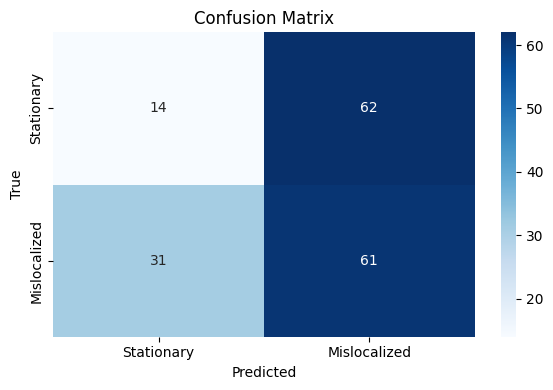

In [158]:
cm = confusion_matrix(mutated['mislocalized'], mutated['pred_mislocalized_from_true_wt'])

cm_df = pd.DataFrame(cm, 
                     index=['Stationary', 'Mislocalized'], 
                     columns=['Stationary', 'Mislocalized'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/lacoste_confusion_matrix1.pdf", bbox_inches='tight', dpi=300)
plt.show()


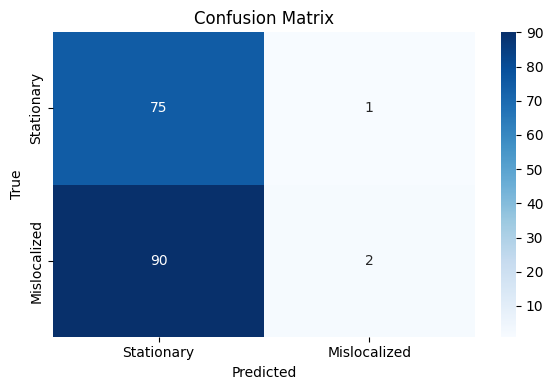

In [159]:
#Question: Should we count as mislocalized if there is a difference between the predict wt and the predicted mutation
# or if there is a difference from the true wt and the predict mutation
# Probably pick the former because the wt predictions are already so bad

cm = confusion_matrix(mutated['mislocalized'], mutated['pred_mislocalized_from_pred_wt'])

cm_df = pd.DataFrame(cm, 
                     index=['Stationary', 'Mislocalized'], 
                     columns=['Stationary', 'Mislocalized'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/lacoste_confusion_matrix2.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [29]:
# List of proteins that model correctly predicts as mislocalized
temp = lacoste_metadata[lacoste_metadata.mutated]
temp[temp.wt_pred != temp.predicted_loc][["Uniprot", "Variant", "level1", "predicted_loc", "wt_locs", "wt_pred_locs"]]

,Uniprot,Variant,level1,predicted_loc,wt_locs,wt_pred_locs
137,P56539,CAV3 D28E,{golgi-apparatus},"{vesicles, plasma-membrane}",{plasma-membrane},{plasma-membrane}
142,P58418,CLRN1 S105P,{endoplasmic-reticulum},"{vesicles, plasma-membrane}",{vesicles},{plasma-membrane}
203,Q9GZU1,MCOLN1 D362Y,{endoplasmic-reticulum},"{endosomes, vesicles, plasma-membrane}",{vesicles},"{endosomes, plasma-membrane}"
223,Q01453,PMP22 L16P,{endoplasmic-reticulum},{plasma-membrane},{plasma-membrane},"{vesicles, plasma-membrane}"
230,O14593,RFXANK L195P,{cytosol},"{nucleoplasm, cytosol}","{nucleoplasm, cytosol}",{cytosol}
247,P11166,SLC2A1 P485L,{golgi-apparatus},"{endosomes, plasma-membrane}",{plasma-membrane},{plasma-membrane}
299,P56539,CAV3 G56S,{plasma-membrane},"{vesicles, plasma-membrane}",{plasma-membrane},{plasma-membrane}
300,P56539,CAV3 S141R,{plasma-membrane},"{vesicles, plasma-membrane}",{plasma-membrane},{plasma-membrane}
301,P56539,CAV3 T78M,{plasma-membrane},"{vesicles, plasma-membrane}",{plasma-membrane},{plasma-membrane}
362,P35240,NF2 R418C,{cytosol},"{actin-filaments, plasma-membrane, cytosol}",{cytosol},"{plasma-membrane, cytosol}"


In [187]:
wildtype[wildtype.unmutated_z_attention.isna()]

,Uniprot,Gene,Variant,location,sequence,mislocalized,mutated,level1,level2,level3,...,targets,wt_attention,z_attention,z_wt_attention,norm_attention,norm_wt_attention,mutated_z_attention,unmutated_z_attention,mutated_norm_attention,unmutated_norm_attention
1,O43707,ACTN4,ACTN4,Actin,MVDYHAANQSYQYGPSSAGNGAGGGGSMGDYMAQEDDWDRDLLLDP...,False,False,"{actin-filaments, cytoskeleton}",cytoskeleton,cytoskeleton,...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(3.5955), tensor(3.2745), tensor(0.8290...","[tensor(3.5955), tensor(3.2745), tensor(0.8290...","[tensor(0.2322), tensor(0.2137), tensor(0.0730...","[tensor(0.2322), tensor(0.2137), tensor(0.0730...",NaN,NaN,NaN,NaN
3,Q15848,ADIPOQ,ADIPOQ,Vesicles,MLLLGAVLLLLALPGHDQETTTQGPGVLLPLPKGACTGWMAGIPGH...,False,False,{vesicles},vesicles,endomembrane-system,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(1.4735), tensor(3.1415), tensor(4.2122...","[tensor(1.4735), tensor(3.1415), tensor(4.2122...","[tensor(0.4240), tensor(0.7748), tensor(1.), t...","[tensor(0.4240), tensor(0.7748), tensor(1.), t...",NaN,NaN,NaN,NaN
4,P07550,ADRB2,ADRB2,Plasma membrane,MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...,False,False,{plasma-membrane},plasma-membrane,plasma-membrane,...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(0.7183), tensor(0.7400), tensor(0.6426...","[tensor(0.7183), tensor(0.7400), tensor(0.6426...","[tensor(0.1875), tensor(0.1904), tensor(0.1777...","[tensor(0.1875), tensor(0.1904), tensor(0.1777...",NaN,NaN,NaN,NaN
5,P23526,AHCY,AHCY,Cellular periphery,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMRERYSASKPLK...,False,False,{plasma-membrane},plasma-membrane,plasma-membrane,...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(3.2467), tensor(5.7915), tensor(2.1555...","[tensor(3.2467), tensor(5.7915), tensor(2.1555...","[tensor(0.1642), tensor(0.2768), tensor(0.1159...","[tensor(0.1642), tensor(0.2768), tensor(0.1159...",NaN,NaN,NaN,NaN
6,P31749,AKT1,AKT1,Cellular periphery,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,False,False,{plasma-membrane},plasma-membrane,plasma-membrane,...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(1.5905), tensor(6.8978), tensor(0.8132...","[tensor(1.5905), tensor(6.8978), tensor(0.8132...","[tensor(0.2024), tensor(0.6787), tensor(0.1326...","[tensor(0.2024), tensor(0.6787), tensor(0.1326...",NaN,NaN,NaN,NaN
7,Q9UM73,ALK,ALK,Plasma membrane,MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSY...,False,False,{plasma-membrane},plasma-membrane,plasma-membrane,...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(-0.2184), tensor(-0.4553), tensor(-0.3...","[tensor(-0.2184), tensor(-0.4553), tensor(-0.3...","[tensor(0.0229), tensor(0.0058), tensor(0.0107...","[tensor(0.0229), tensor(0.0058), tensor(0.0107...",NaN,NaN,NaN,NaN
9,P03950,ANG,ANG,Plasma membrane,MVMGLGVLLLVFVLGLGLTPPTLAQDNSRYTHFLTQHYDAKPQGRD...,False,False,{plasma-membrane},plasma-membrane,plasma-membrane,...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(2.0783), tensor(3.0147), tensor(2.0715...","[tensor(2.0783), tensor(3.0147), tensor(2.0715...","[tensor(0.5510), tensor(0.7587), tensor(0.5494...","[tensor(0.5510), tensor(0.7587), tensor(0.5494...",NaN,NaN,NaN,NaN
13,Q3SXY8,ARL13B,ARL13B,Plasma membrane,MFSLMASCCGWFKRWREPVRKVTLLMVGLDNAGKTATAKGIQGEYP...,False,False,{plasma-membrane},plasma-membrane,plasma-membrane,...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(0.0010), tensor(0.0010), tensor(0.0010...","[tensor(0.9651), tensor(1.7222), tensor(0.8215...","[tensor(0.9651), tensor(1.7222), tensor(0.8215...","[tensor(0.1617), tensor(0.2367),

In [189]:
background_z_attn = np.array(lacoste_metadata.z_attention.apply(lambda x: x.numpy()).to_list()).flatten()
background_norm_attn = np.array(lacoste_metadata.norm_attention.apply(lambda x: x.numpy()).to_list()).flatten()

wildtype_z_attn = sum(mutated.unmutated_z_attention.to_list(), []) #variant rows have the attention from the wildtype seq in "unmutated_z_attention" col
wildtype_z_attn = np.array(wildtype_z_attn)
mutated_z_attn = sum(mutated.mutated_z_attention.to_list(), [])
mutated_z_attn = np.array(mutated_z_attn)
mislocalized_z_attn = sum(mislocalized.mutated_z_attention.to_list(), [])
mislocalized_z_attn = np.array(mislocalized_z_attn)
stationary_z_attn = sum(stationary.mutated_z_attention.to_list(), [])
stationary_z_attn = np.array(stationary_z_attn)

wildtype_norm_attn = sum(mutated.unmutated_norm_attention.to_list(), [])
wildtype_norm_attn = np.array(wildtype_norm_attn)
mutated_norm_attn = sum(mutated.mutated_norm_attention.to_list(), [])
mutated_norm_attn = np.array(mutated_norm_attn)
mislocalized_norm_attn = sum(mislocalized.mutated_norm_attention.to_list(), [])
mislocalized_norm_attn = np.array(mislocalized_norm_attn)
stationary_norm_attn = sum(stationary.mutated_norm_attention.to_list(), [])
stationary_norm_attn = np.array(stationary_norm_attn)

In [190]:
#PEARSONE CORRELATION COEFF
from scipy.stats.stats import pearsonr   

pearsonr(mutated_z_attn, wildtype_z_attn)

/tmp/ipykernel_93311/3037819251.py:2: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.9999986307708874, pvalue=0.0)

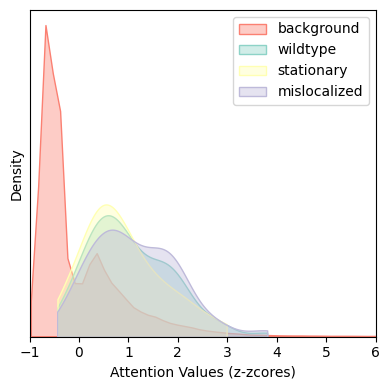

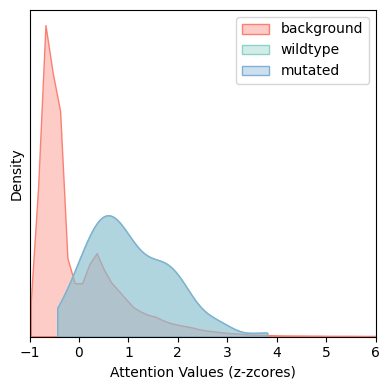

In [191]:
palette = sns.color_palette("Set3")

plt.figure(figsize=(4, 4))
sns.kdeplot(background_z_attn, label='background', fill=True, color=palette[3], linewidth=1, bw_adjust=1, alpha=0.4, cut=0)
sns.kdeplot(wildtype_z_attn, label='wildtype', fill=True, color=palette[0], linewidth=1, bw_adjust=1, alpha=0.4,cut=0)
sns.kdeplot(stationary_z_attn, label='stationary', fill=True, color=palette[1], linewidth=1, bw_adjust=1, alpha=0.4,cut=0)
sns.kdeplot(mislocalized_z_attn, label='mislocalized', fill=True, color=palette[2], linewidth=1, bw_adjust=1, alpha=0.4,cut=0)

plt.xlabel('Attention Values (z-zcores)')
plt.xlim(-1, 6)
plt.ylabel('Density')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/lacoste_attention1.pdf", bbox_inches='tight', dpi=300)
plt.show()

palette = sns.color_palette("Set3")

plt.figure(figsize=(4, 4))
sns.kdeplot(background_z_attn, label='background', fill=True, color=palette[3], linewidth=1, bw_adjust=1, alpha=0.4, cut=0)
sns.kdeplot(wildtype_z_attn, label='wildtype', fill=True, color=palette[0], linewidth=1, bw_adjust=1, alpha=0.4,cut=0)
sns.kdeplot(mutated_z_attn, label='mutated', fill=True, color=palette[4], linewidth=1, bw_adjust=1, alpha=0.4,cut=0)

plt.xlabel('Attention Values (z-zcores)')
plt.xlim(-1, 6)
plt.ylabel('Density')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/lacoste_attention2.pdf", bbox_inches='tight', dpi=300)
plt.show()